In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import njit

from joblib import Parallel, delayed

In [2]:
def solve_laplace_absorbing_bottom(nx, ny, C0, k, mask, tol=1e-6, max_iter=20000, omega=1.0):
    """
    Solve ∇²C=0 on an (nx, ny) grid with:
      - Top (y=ny-1): C = C0
      - Left/right: dC/dx = 0
      - Bottom (y=0): dC/dy = k*C, except where mask[x]==1 -> dC/dy = 0

    Grid indexing: C[x, y], x=0..nx-1 (left→right), y=0..ny-1 (bottom→top).
    Uses Gauss–Seidel (omega=1.0). Set 1<omega<2 for SOR.

    Returns:
      C  : (nx, ny) array
      it : iterations used
    """
    mask = np.asarray(mask, dtype=bool)
    assert mask.shape == (nx,), "mask must have length nx"

    C = np.full((nx, ny), float(C0))  # good initial guess (speeds convergence)
    C[:, ny-1] = C0                   # enforce top Dirichlet

    for it in tqdm(range(1, max_iter + 1)):
        max_change = 0.0

        # Sweep all rows except the top (Dirichlet)
        for y in range(ny - 1):
            for x in range(nx):
                # Left/right neighbors with Neumann mirror
                left  = C[1, y]        if x == 0      else C[x - 1, y]
                right = C[nx - 2, y]   if x == nx - 1 else C[x + 1, y]

                # Top neighbor exists because y <= ny-2
                top = C[x, y + 1]  # top row already fixed to C0

                if y == 0:
                    # Bottom boundary handling
                    if mask[x]:
                        # Zero-flux: ghost = C[x,1]
                        numer = left + right + top + C[x, 1]
                        denom = 4.0
                        newC = numer / denom
                    else:
                        # Robin dC/dy = k*C using central derivative:
                        # (C[x,1] - C_ghost)/(2*dy) = k*C[x,0]  =>  C_ghost = C[x,1] - 2*k*dy*C[x,0]
                        # Plug ghost into 5-pt Laplace update and solve for C[x,0]:
                        numer = left + right + top + C[x, 1]
                        denom = 4.0 + 2.0 * k  # dy=1
                        newC = numer / denom
                else:
                    # Interior: standard Laplace update
                    bottom = C[x, y - 1]
                    newC = 0.25 * (left + right + top + bottom)

                old = C[x, y]
                C[x, y] = (1.0 - omega) * old + omega * newC
                max_change = max(max_change, abs(C[x, y] - old))

        # Re-enforce top boundary (already constant, but keep explicit)
        C[:, ny - 1] = C0

        if max_change < tol:
            return C, it

    return C, max_iter

In [3]:
@njit(cache=True, fastmath=True)
def solve_core(nx, ny, C0, k, mask_u8, tol, max_iter, omega):
    C = np.full((nx, ny), C0)
    # enforce top boundary (Dirichlet)
    for x in range(nx):
        C[x, ny - 1] = C0

    for it in range(1, max_iter + 1):
        max_change = 0.0

        # sweep all rows except the top (Dirichlet)
        for y in range(ny - 1):
            for x in range(nx):
                # left/right neighbors with Neumann mirrors
                if x == 0:
                    left = C[1, y]
                else:
                    left = C[x - 1, y]

                if x == nx - 1:
                    right = C[nx - 2, y]
                else:
                    right = C[x + 1, y]

                top = C[x, y + 1]  # valid since y <= ny-2

                if y == 0:
                    # bottom boundary
                    if mask_u8[x] == 1:
                        # zero-flux: ghost = C[x,1]
                        numer = left + right + top + C[x, 1]
                        denom = 4.0
                        newC = numer / denom
                    else:
                        # Robin dC/dy = k*C  ->  C0 = (left+right+top+C1)/(4+2k)
                        numer = left + right + top + C[x, 1]
                        denom = 4.0 + 2.0 * k  # dy=1
                        newC = numer / denom
                else:
                    bottom = C[x, y - 1]
                    newC = 0.25 * (left + right + top + bottom)

                old = C[x, y]
                Cxy = (1.0 - omega) * old + omega * newC
                C[x, y] = Cxy

                diff = Cxy - old
                if diff < 0.0:
                    diff = -diff
                if diff > max_change:
                    max_change = diff

        # re-enforce top boundary explicitly (keeps round-off in check)
        for x in range(nx):
            C[x, ny - 1] = C0

        if max_change < tol:
            print("converged")
            return C, it, max_change

    return C, max_iter, max_change

In [104]:
zoom = 4
nx, ny = 100 * zoom, 50 * zoom
C0 = 1.0         # top concentration
k = 1/12.5          # absorption strength (per grid cell)

non_absorb_mask = np.zeros(nx, dtype=bool)
gap = 16
width = 25
non_absorb_mask[nx//2 - gap//2 - width: nx//2- gap//2] = True
non_absorb_mask[nx//2 + gap//2 : nx//2 + gap//2 + width] = True

C, iters, maxchange = solve_core(nx, ny, C0, k, non_absorb_mask, tol=1e-5, max_iter=20000, omega=1.2)
print(f"Solved in {iters} iterations. Array shape: {C.shape}")
print(f"Max change: {maxchange}")

converged
Solved in 14614 iterations. Array shape: (400, 200)
Max change: 9.999785229197755e-06


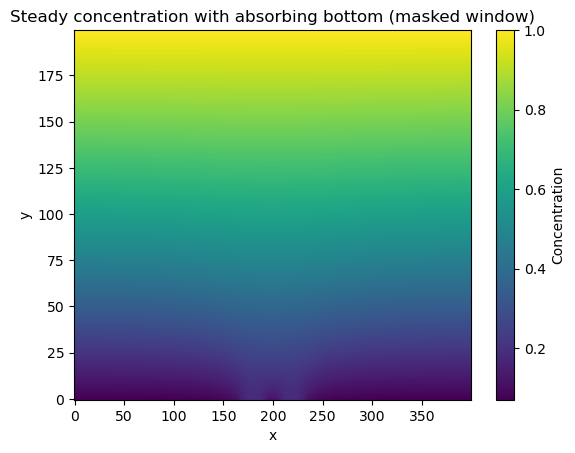

In [105]:

plt.imshow(C.T, origin="lower", aspect="auto")
plt.colorbar(label="Concentration")
plt.title("Steady concentration with absorbing bottom (masked window)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

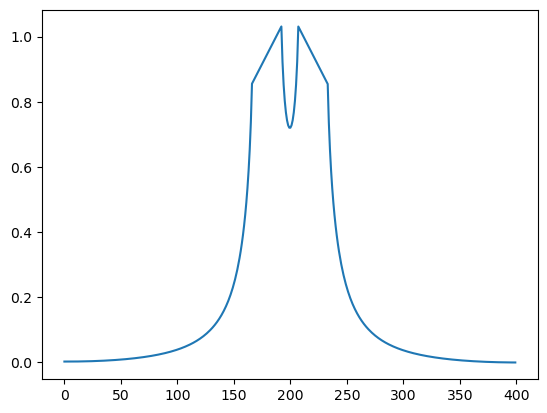

In [106]:

background_value = np.min(C[:, 0])
extra_thickness = C[:, 0] - background_value #+ 1e-6
normalized_thickness = extra_thickness/ background_value

plt.plot(np.arange(nx)[non_absorb_mask == 0], normalized_thickness[non_absorb_mask == 0])

In [107]:
def _single_run(absorption_rate):

    absorption_coefficient = 1/absorption_rate

    C, iters, maxchange = solve_core(nx, ny, C0, absorption_rate, non_absorb_mask, tol=1e-5, max_iter=20000, omega=1.2)

    return C[:, 0], C[0, :]


def parameter_sweep_parallel(num, n_jobs=2, backend="loky"):
    a = np.linspace(-3.5, -0.5, num = num, endpoint = True)
    absorption_rates = np.power(10, a)

    a = np.linspace(5, 150, num = num, endpoint = True)
    absorption_rates = 1/a

    print(absorption_rates)

    results = Parallel(n_jobs=n_jobs, backend=backend)(
        delayed(_single_run)(absorption_rate)
        for absorption_rate in absorption_rates
    )

    thickness_bottom, thickness_left = zip(*results)
    return absorption_rates, thickness_bottom, thickness_left

In [108]:
absorption_rates, thickness_bottom, concentration_left = parameter_sweep_parallel(num = 10, n_jobs=-1, backend="loky")

[0.2        0.04736842 0.02686567 0.01875    0.0144     0.01168831
 0.00983607 0.00849057 0.00746888 0.00666667]


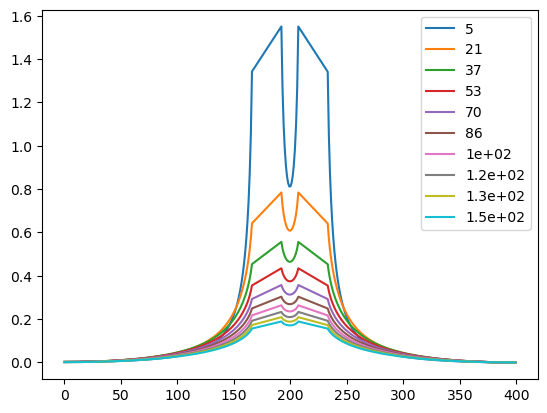

In [113]:
#print(absorption_rates)

for i in range(10):
    background_value = np.min(thickness_bottom[i])
    extra_thickness = thickness_bottom[i] - background_value #+ 1e-6
    normalized_thickness = extra_thickness/ background_value


    slope = concentration_left[i][1]-concentration_left[i][0]

    #plt.plot(np.arange(50), np.arange(50)*slope + concentration_left[i][0])

    measured_absorption = slope/concentration_left[i][0]

    plt.plot(np.arange(nx)[non_absorb_mask == 0], normalized_thickness[non_absorb_mask == 0], label=f"{1/measured_absorption:.2g}")

#plt.xlim(nx//2, nx//2 + 100)
#plt.yscale('log')
plt.legend()

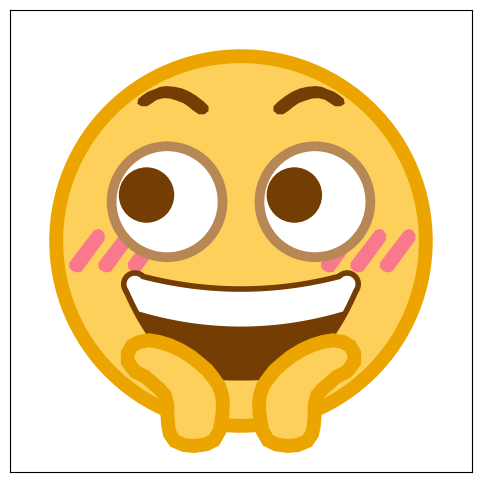

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# ---- Colors (RGB normalized) ----
face_edge = np.array([236, 165,   0]) / 255.0
face_fill = np.array([253, 208,  91]) / 255.0
pink      = np.array([248, 121, 139]) / 255.0
brown     = np.array([116,  61,   4]) / 255.0
eye_edge  = np.array([183, 135,  86]) / 255.0
white     = np.array([1.0,   1.0, 1.0])

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_xticks([])
ax.set_yticks([])
ax.set_box_aspect(1)

# ---- Face circle ----
ax.add_patch(Circle((0, 0), radius=8.0, facecolor=face_fill, edgecolor=face_edge, linewidth=10))

# ---- Cheek stripes (six patches) ----
y = np.array([-0.9432, 0.4541, 0.5240, 0.4541, 0.2795, 0.0349, -1.3275, -1.3624, -1.2926, -1.1528])
x1 = np.array([-7.4373, -6.3692, -6.1565, -6.0152, -5.8921, -5.9109, -6.9081, -7.1206, -7.2973, -7.4383])
x2 = x1 + 1.27
x3 = x2 + 1.27
x4 = x1 + 13.45
x5 = x4 - 1.27
x6 = x5 - 1.27
for xs in (x1, x2, x3, x4, x5, x6):
    ax.fill(xs, y, facecolor=pink, edgecolor='none')

# ---- Mouth/Brown outline + white interior ----
r = 0.3602
theta = np.linspace(-0.6714, -0.6714 + np.pi, 100)

f = lambda x: 0.032 * x**3 - 5.8
g = lambda x: 0.03  * x**2 - 2.2
h = lambda x: 0.0334 * x**2 - 3.703

x1 = np.linspace(0.0, 4.876, 200)
x2 = r * np.cos(theta) + 4.594
x3 = np.linspace(4.312, 0.0, 200)
x4 = np.linspace(0.0, 4.411, 200)
x5 = np.linspace(4.411, 4.876, 50)

y1 = f(x1)
y2 = r * np.sin(theta) - 1.8662
y3 = g(x3)

# Brown outer shape
x = np.concatenate([x1, x2, x3])
y = np.concatenate([y1, y2, y3])
X = np.concatenate([x, -np.flip(x)])
Y = np.concatenate([y,  np.flip(y)])
ax.fill(X, Y, facecolor=brown, edgecolor=brown, linewidth=8)

# White inner shape
y4 = h(x4)
y5 = f(x5)
x_inner = np.concatenate([x4, x5, x2, x3])
y_inner = np.concatenate([y4, y5, y2, y3])
Xw = np.concatenate([x_inner, -np.flip(x_inner)])
Yw = np.concatenate([y_inner,  np.flip(y_inner)])
ax.fill(Xw, Yw, facecolor=white, edgecolor='none')

# ---- Eye whites (two circles) ----
eye_r = 2.4
ax.add_patch(Circle((-3.2, 1.7), radius=eye_r, facecolor=white, edgecolor=eye_edge, linewidth=7))
ax.add_patch(Circle(( 3.2, 1.7), radius=eye_r, facecolor=white, edgecolor=eye_edge, linewidth=7))

# ---- State 1: pupils + brows/accents ----
# Pupils
pupil_r = 1.2
ax.add_patch(Circle((-4.09, 1.99), radius=pupil_r, facecolor=brown, edgecolor='none'))
ax.add_patch(Circle(( 2.31, 1.99), radius=pupil_r, facecolor=brown, edgecolor='none'))  # -4.09 + 6.4

# Upper accents (brown), mirrored
x_top = np.array([1.4068, 1.6201, 1.9398, 2.2238, 2.5430, 2.8618, 3.2160, 3.4990, 3.7463, 4.0291,
                  4.2408, 4.4524, 4.4869, 4.3095, 4.0617, 3.8499, 3.6381, 3.3553, 3.0720, 2.7884,
                  2.5048, 2.2740, 2.0608, 1.8300, 1.5823, 1.4059])
y_top = np.array([5.8341, 6.0437, 6.2882, 6.4629, 6.6026, 6.6725, 6.7074, 6.6725, 6.5677, 6.4629,
                  6.3231, 6.1485, 5.9389, 5.8341, 5.8341, 5.9738, 6.1135, 6.1834, 6.1659, 6.0786,
                  5.9738, 5.8166, 5.6419, 5.4847, 5.4847, 5.6245])
ax.fill(x_top,  y_top, facecolor=brown, edgecolor='none')
ax.fill(-x_top, y_top, facecolor=brown, edgecolor='none')

# Lower gold accents (face color with orange edge), mirrored
x_low = np.array([1.7823, 2.1730, 2.6345, 3.0956, 3.5564, 3.9815, 4.4059, 4.7237, 4.8993, 4.8976,
                  4.5772, 4.1515, 3.8672, 3.5474, 3.2984, 3.1903, 3.1885, 3.1509, 3.0786, 2.8648,
                  2.4392, 2.0143, 1.5190, 1.1658, 0.9375, 0.8508, 0.7994, 0.7836, 0.8205, 0.9639,
                  1.2133, 1.4625])
y_low = np.array([-5.3100, -4.9956, -4.7162, -4.5066, -4.3668, -4.2969, -4.3668, -4.5415, -4.8559,
                  -5.2402, -5.6594, -5.8690, -6.1135, -6.3930, -6.6725, -7.0917, -7.5109, -8.0000,
                  -8.3493, -8.6638, -8.8384, -8.8734, -8.8035, -8.6288, -8.2271, -7.8253, -7.4410,
                  -7.0218, -6.6725, -6.2533, -5.9039, -5.5895])
ax.fill( x_low,  y_low, facecolor=face_fill, edgecolor=face_edge, linewidth=10)
ax.fill(-x_low,  y_low, facecolor=face_fill, edgecolor=face_edge, linewidth=10)

plt.show()


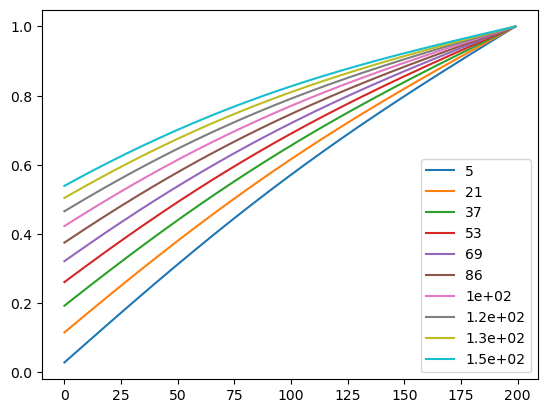

In [110]:
for i in range(10):
    plt.plot(concentration_left[i], label=f"{1/absorption_rates[i]:.2g}")

plt.legend()

0.006794283568126186
147.18255279942528


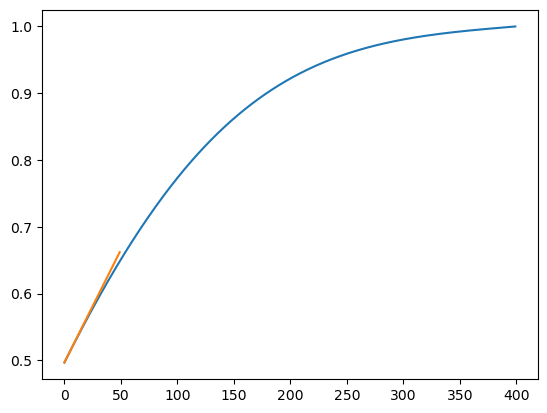

In [80]:
plt.plot(concentration_left[4])

slope = concentration_left[4][1]-concentration_left[4][0]

plt.plot(np.arange(50), np.arange(50)*slope + concentration_left[4][0])

measured_absorption = slope/concentration_left[4][0]

print(measured_absorption)
print(1/measured_absorption)

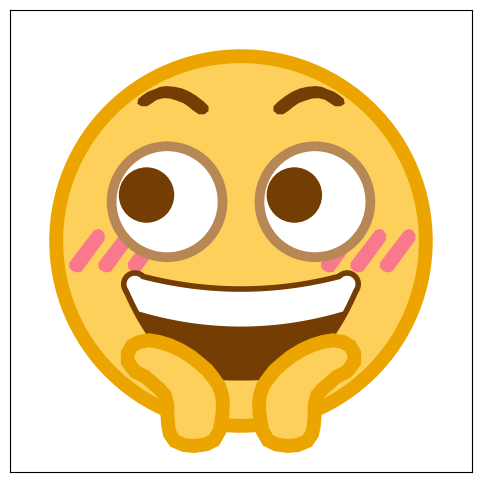